# Tutorial - Green Urban Scenarious
A demo of a minimal flow of GUS process.

For more advanced use cases, please see upcoming article. For more structured experiment and scenario analyis plese see model sepcification and code documentation within docs/ folder. 

In [1]:
# Install the GUS framework.

import sys

!{sys.executable} -m pip install pygus==1.0


[notice] A new release of pip available: 22.3.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


In [2]:
# %load_ext autoreload
%reload_ext autoreload
%autoreload 3
%matplotlib inline
from pkg_resources import resource_filename
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os, sys, json
import pkgutil
import pprint

root_dir = os.path.abspath(os.path.join(os.getcwd(), "../"))

pp = pprint.PrettyPrinter(indent=1)
sns.set_theme()

/var/folders/sq/279ztff55tg817zzbvzd4p0c0000gn/T/ipykernel_12721/1628925198.py:5: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_filename


## 0. Importing GUS modules

In [3]:
from pygus.gus.models import Urban
from pygus.gus.utilities import get_raster_data

## 1. Initilisation

### 1.1 Importing data on site, tree populations, experiment parameters

In [4]:
# File that holds site/city other geolocated data and parameters
fname_config_site = os.path.join(root_dir, "pygus", "gus", "inputs", "site.json")

# File that include tree species specific parameters
# resource_filename("pygus", "gus/inputs/allometrics.json")
fname_config_allometrics = os.path.join(
    root_dir, "pygus", "gus", "inputs", "allometrics.json"
)

# File that include individual tree data including their location on a 2D raster of the actual location
# resource_filename("pygus", "gus/inputs/trees.csv")
fname_data_trees = os.path.join(root_dir, "pygus", "gus", "inputs", "trees.csv")

# File that holds experiment parameters
# resource_filename("pygus", "gus/inputs/scenario.json")
fname_scenario_params = os.path.join(
    root_dir, "pygus", "gus", "inputs", "scenario.json"
)

In [5]:
f = open(fname_config_allometrics)
config_allometrics = json.loads(f.read())
# pp.pprint(config_allometrics)

In [6]:
f = open(fname_config_site)
config_site = json.loads(f.read())
pp.pprint(config_site)

{'impervious_m2': 500,
 'pervious_m2': 500,
 'project_site_type': 'park',
 'total_m2': 1000,
 'tree_density_per_ha': 400,
 'weather': {'growth_season_mean': 200, 'growth_season_var': 7}}
{'total_m2': 1000, 'impervious_m2': 500, 'pervious_m2': 500, 'tree_density_per_ha': 400, 'weather': {'growth_season_mean': 200, 'growth_season_var': 7}, 'project_site_type': 'park'}


In [7]:
df_pop = pd.read_csv(fname_data_trees)
df_pop.tail()

,id,species,dbh,height,condition,xpos,ypos
95,96,conifer,13.871098,3.303454,good,17,4
96,97,conifer,12.561324,3.165903,good,17,5
97,98,conifer,13.651542,3.436859,good,17,6
98,99,conifer,12.610441,3.195499,good,17,3
99,100,conifer,12.491068,3.467151,excellent,17,7


In [8]:
f = open(fname_scenario_params)
scenario_params = json.loads(f.read())
pp.pprint(scenario_params)

{'is_crownsunexposure_fixed': 1,
 'maintenance_scope': 1,
 'time_horizon_years': 50}


### 1.2 Creating a digital twin of the site

In [9]:
site = Urban(df_pop, fname_config_allometrics, fname_config_site, scenario_params)

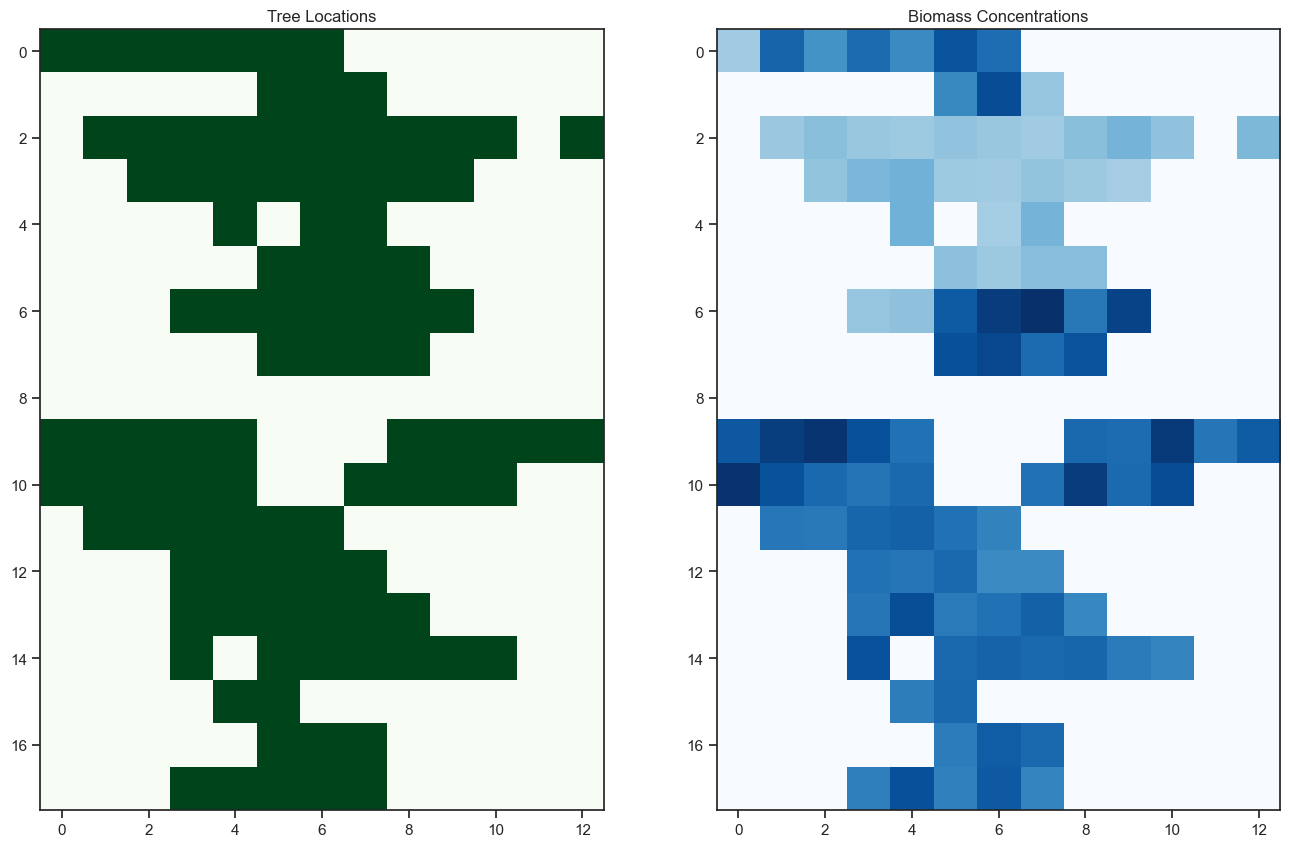

In [10]:
initial_locations = get_raster_data(site, counts=True)
initial_biomass = get_raster_data(site, var="biomass")

sns.set_style("ticks")
fig = plt.figure(figsize=(16, 12))
plt.subplot(121)
plt.imshow(initial_locations, cmap="Greens")
plt.title("Tree Locations")
plt.subplot(122)
plt.title("Biomass Concentrations")
plt.imshow(initial_biomass, cmap="Blues")
# plt.colorbar(label = 'Biomass - Kg')
plt.show()

## 2. Running the scenario

In [11]:
for i in range(scenario_params["time_horizon_years"]):
    site.step()

## 3. Analysis

### 3.1 Individual tree level inspections 

In [12]:
# Tree level individual variables
df_out_tree = site.datacollector.get_agent_vars_dataframe()
# df_out_tree.to_csv("trees_yearly.json", index=True)
df_out_tree.tail()

species        dbh    height    crownH    crownW  \
Step AgentID                                                     
50   315      conifer  10.026511  6.348760  4.026243  2.523319   
     316       decidu   8.955727  8.196463  4.190011  3.630394   
     317      conifer   9.014472  5.772960  3.757091  2.333097   
     318       decidu   9.124893  8.280204  4.237188  3.670957   
     319       decidu   9.118561  8.277082  4.235425  3.669441   

              canopy_overlap      cle  condition   dieback    biomass  \
Step AgentID                                                            
50   315            0.966823  0.52262  excellent  0.001010  35.323498   
     316            1.000000  0.00000  excellent  0.004002  32.867100   
     317            0.000000  0.56000  excellent  0.007787  27.229216   
     318            0.000000  0.56000  excellent  0.004879  34.280628   
     319            0.000000  0.56000  excellent  0.007190  34.227126   

                   seq     carbon  deroot  detrunk   mulched  burnt  \
Step AgentID                                                          
50   315      1.700433  17.661749     0.0      0.0  0.000892    0.0   
     316      0.000000  16.433550     0.0      0.0  0.003288    0.0   
     317      0.000000  13.614608     0.0      0.0  0.000000    0.0   
     318      0.000000  17.140314     0.0      0.0  0.000000    0.0   
     319      0.000000  17.113563     0.0      0.0  0.000000    0.0   

             coordinates  
Step AgentID              
50   315         (13, 4)  
     316          (6, 7)  
     317         (14, 6)  
     318          (5, 7)  
     319          (6, 4)

In [13]:
Specific_Tree = df_out_tree.xs(42, level="AgentID")
Specific_Tree.tail()

,species,dbh,height,crownH,crownW,canopy_overlap,cle,condition,dieback,biomass,seq,carbon,deroot,detrunk,mulched,burnt,coordinates
Step,,,,,,,,,,,,,,,,,
46,decidu,40.221207,18.534689,10.667906,9.547379,1.0,0.652625,replaced,1.0,965.388135,0.0,482.694068,0.0,0.0,0.0,0.0,"(6, 8)"
47,decidu,40.221207,18.534689,10.667906,9.547379,1.0,0.652625,replaced,1.0,965.388135,0.0,482.694068,0.0,0.0,0.0,0.0,"(6, 8)"
48,decidu,40.221207,18.534689,10.667906,9.547379,1.0,0.652625,replaced,1.0,965.388135,0.0,482.694068,0.0,0.0,0.0,0.0,"(6, 8)"
49,decidu,40.221207,18.534689,10.667906,9.547379,1.0,0.652625,replaced,1.0,965.388135,0.0,482.694068,0.0,0.0,0.0,0.0,"(6, 8)"
50,decidu,40.221207,18.534689,10.667906,9.547379,1.0,0.652625,replaced,1.0,965.388135,0.0,482.694068,0.0,0.0,0.0,0.0,"(6, 8)"


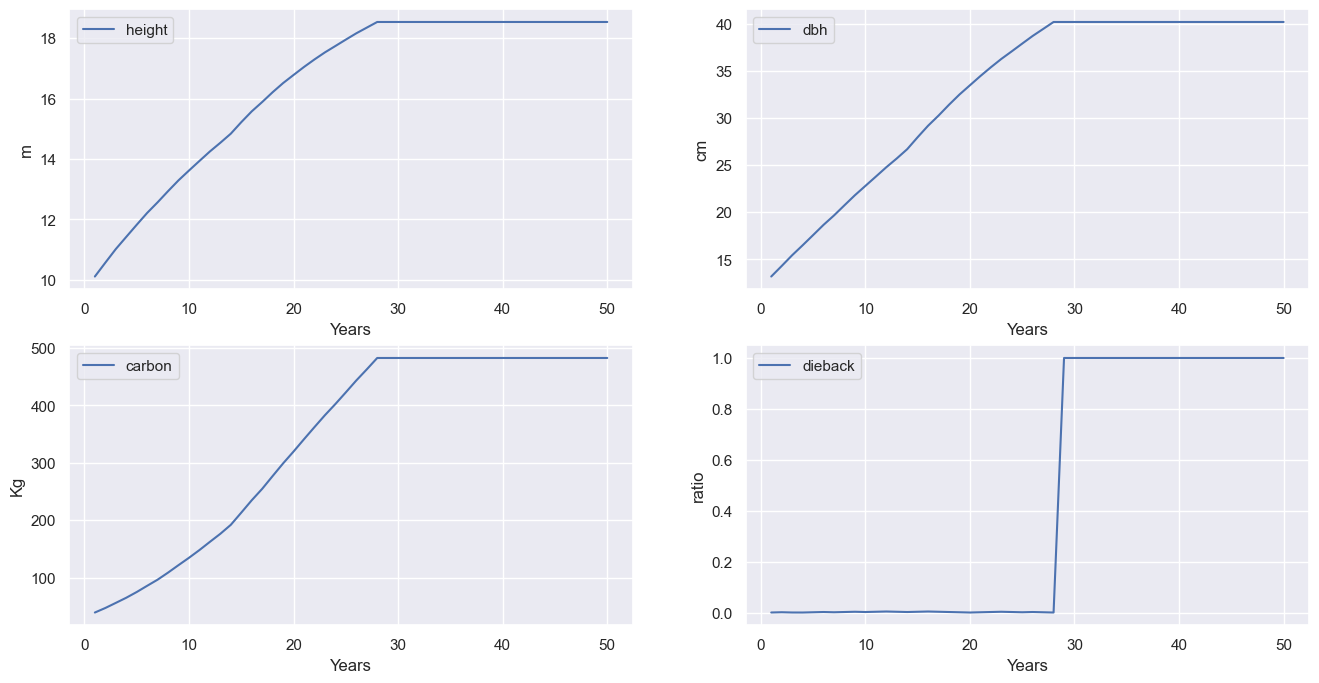

In [14]:
sns.set_theme()
fig = plt.figure(figsize=(16, 8))
plt.subplot(221)
Specific_Tree.height.plot()
plt.xlabel("Years")
plt.ylabel("m")
plt.legend()
plt.subplot(222)
Specific_Tree.dbh.plot()
plt.xlabel("Years")
plt.ylabel("cm")
plt.legend()
plt.subplot(223)
Specific_Tree.carbon.plot()
plt.xlabel("Years")
plt.ylabel("Kg")
plt.legend()
plt.subplot(224)
Specific_Tree.dieback.plot()
plt.xlabel("Years")
plt.ylabel("ratio")
plt.legend()
plt.show()

### 3.2 Site level inspections

In [15]:
# Site level aggregate variables
df_out_site = site.datacollector.get_model_vars_dataframe()
df_out_site.tail()

,Storage,Seq,Released,Alive,Dead,Critical,Dying,Poor,Replaced,Seq_std
45,41124.710590,492.906524,576.250679,83,17,0,0,0,203,4.122174
46,41765.499318,581.477422,301.129183,84,16,0,0,0,207,4.831383
47,42438.984988,546.444535,211.633646,90,10,0,0,0,215,4.455094
48,43008.138390,552.719852,117.320580,90,10,0,0,0,216,4.365575
49,43635.250164,579.243290,241.757443,88,12,0,0,0,219,4.620398


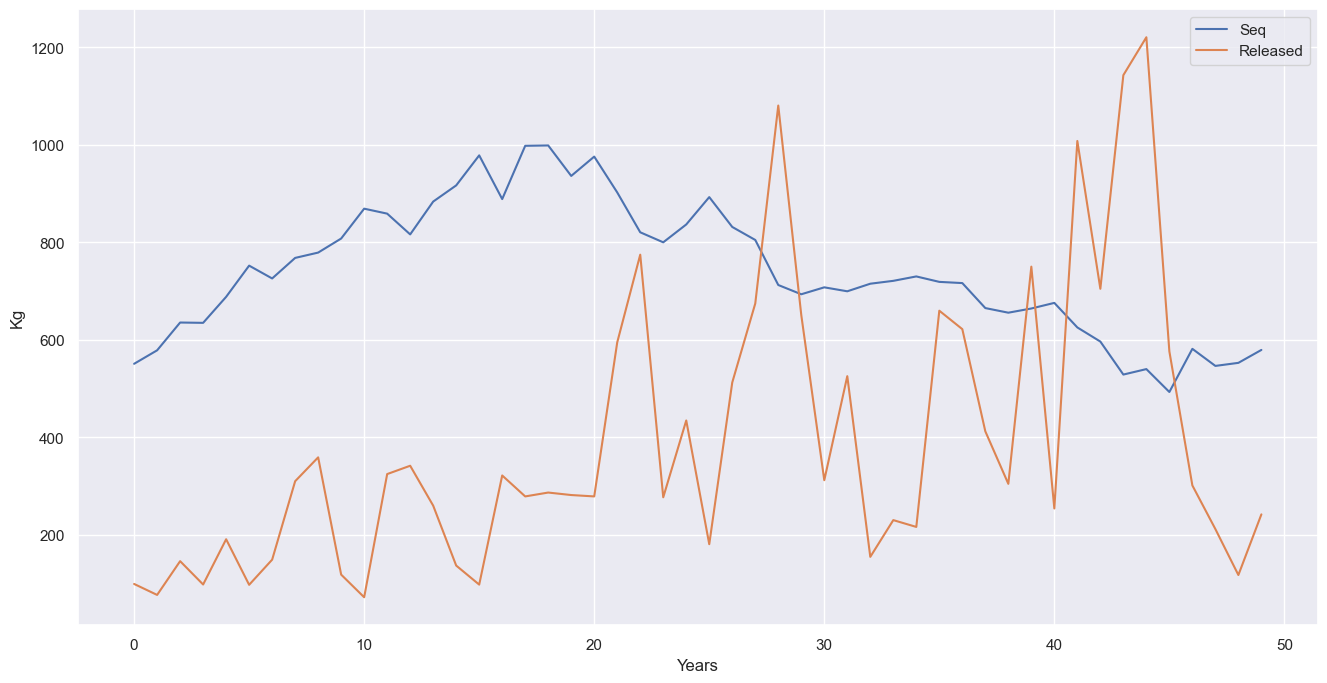

In [16]:
fig = plt.figure(figsize=(16, 8))
df_out_site.Seq.plot()
df_out_site.Released.plot()
plt.xlabel("Years")
plt.ylabel("Kg")
plt.legend()
plt.show()

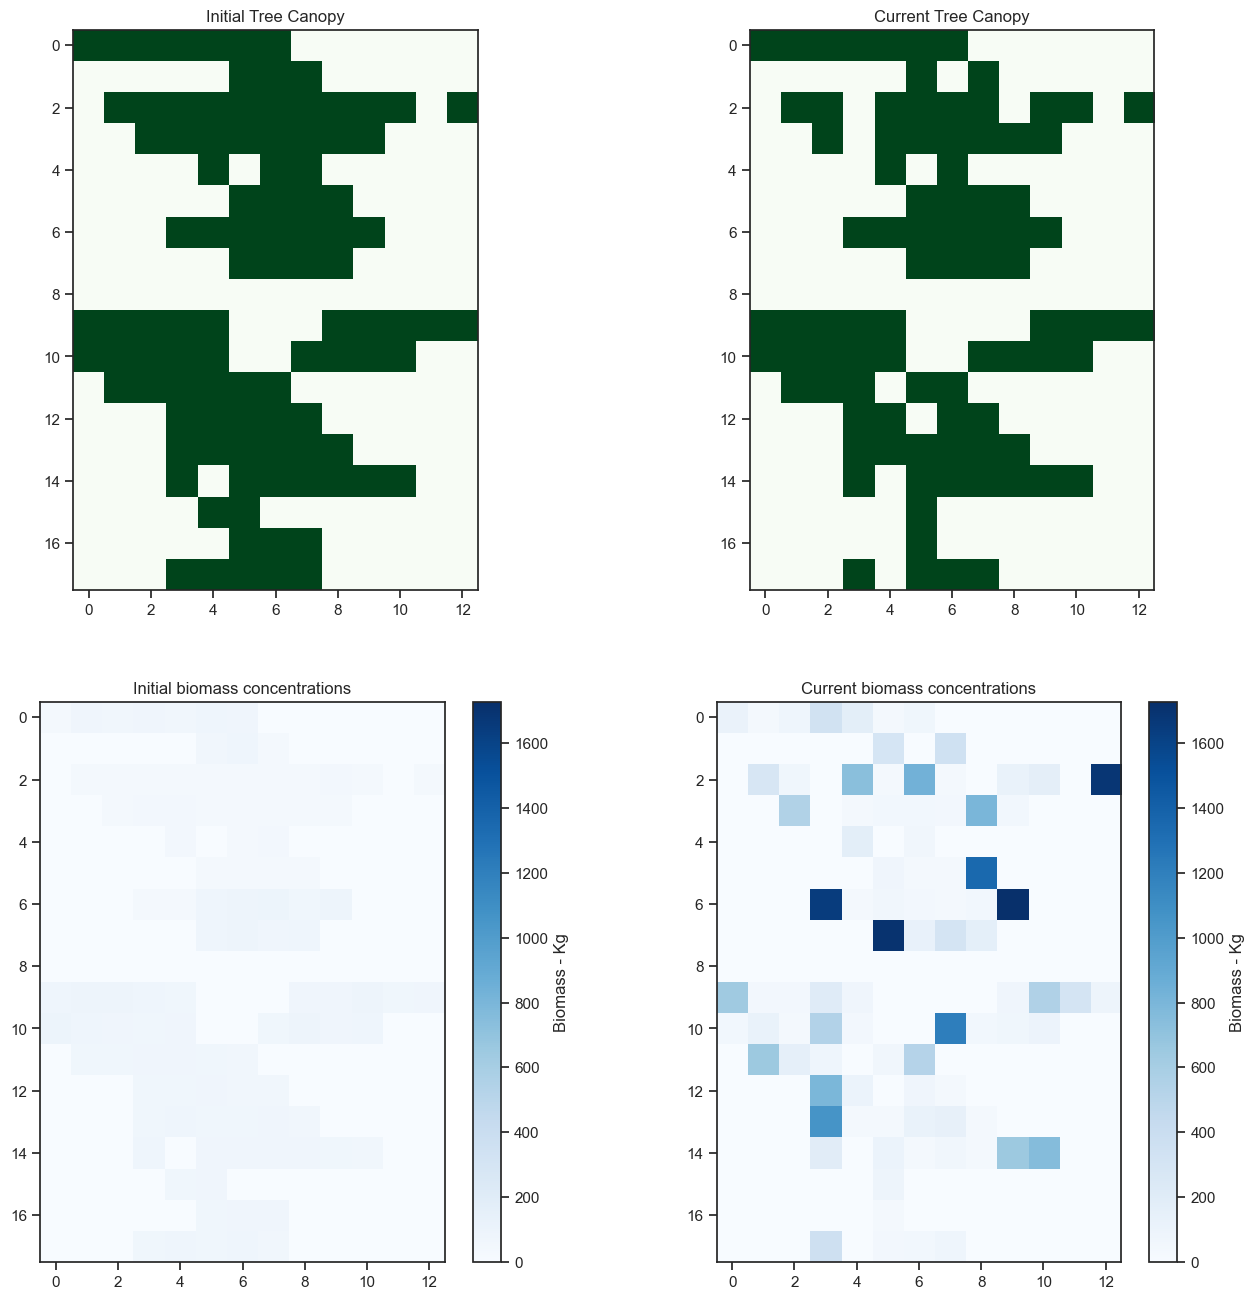

In [17]:
locations = get_raster_data(site, counts=True)
biomass = get_raster_data(site, var="biomass")

sns.set_style("ticks")
fig = plt.figure(figsize=(16, 16))
plt.subplot(221)
plt.imshow(initial_locations, cmap="Greens")
plt.title("Initial Tree Canopy")

plt.subplot(222)
plt.imshow(locations, cmap="Greens")
plt.title("Current Tree Canopy")

plt.subplot(223)
plt.title("Initial biomass concentrations")
plt.imshow(initial_biomass, cmap="Blues", vmin=0, vmax=biomass.max())
plt.colorbar(label="Biomass - Kg")

plt.subplot(224)
plt.title("Current biomass concentrations")
plt.imshow(biomass, cmap="Blues")
plt.colorbar(label="Biomass - Kg")
plt.show()